# AMP-PD Clinical Data Analysis
Transfer entropy across four UPDRS dimensions.

- find $k$ value that optimizes TE, and corresponding TE value.
- find 

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from preprocessing.paths import pointwise_features_path
import jpype


# pointwise_features_path = os.path.join(
#     R"/Volumes/GoogleDrive/My Drive/CRS_CSYS5030/Project/data",
#     "ETL", "clinical_pointwise.csv"
# )
jarLocation = "G:/My Drive/CRS_CSYS5030/jidt/infodynamics.jar"
assert os.path.isfile(jarLocation)

if (not jpype.isJVMStarted()):
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    jpype.startJVM(jpype.getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)

# whole pointwise dataset
df_pointwise = pd.read_csv(pointwise_features_path)
df_pointwise_group = df_pointwise.groupby('patient_id')
# sample patient profile 
df_pointwise_55 = df_pointwise[df_pointwise['patient_id']==55]
df_pointwise_55 = df_pointwise_55[['month']+[f'updrs_{i}_dt' for i in (1,2,3,4)]]
df_pointwise_55 = df_pointwise_55.bfill()
# show heading of pointwise data
df_pointwise.head(3)


,patient_id,month,updrs_1,updrs_2,updrs_3,updrs_4,on_medication,clinical_visit,updrs_1_fit,updrs_2_fit,updrs_3_fit,updrs_4_fit,updrs_1_dt,updrs_2_dt,updrs_3_dt,updrs_4_dt,updrs_1_prev,updrs_2_prev,updrs_3_prev,updrs_4_prev
0,55,0,10.0,6.0,15.0,NaN,NaN,True,8.833333,6.000000,15.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55,1,NaN,NaN,NaN,NaN,NaN,False,8.833333,6.333333,18.333333,0.0,0.0,0.333333,3.333333,0.0,8.833333,6.000000,15.000000,0.0
2,55,2,NaN,NaN,NaN,NaN,NaN,False,8.833333,6.666667,21.666667,0.0,0.0,0.333333,3.333333,0.0,8.833333,6.333333,18.333333,0.0


Function to calculate TE inside a dataframe. Will be applied to dataset group by patient id.

In [3]:
def calculate_te(
        df_input: pd.DataFrame,
        source_column: str,
        target_column: str,
        k_history: int = None,
        k_tau: int = None,
        delay: int = None,
        calc: object = None,
        ) -> float:
    """
    inputs:
    - df_input: dataframe of single patient profile
    - source_column: name of source column in df_input
    - k: number of delays
    outputs:
    - te: transfer entropy of the 
    """
    # 0. Load/prepare the data:
    if source_column not in df_input.columns:
        raise KeyError(f"source column {source_column} not found")
    if target_column not in df_input.columns:
        raise KeyError(f"source column {target_column} not found")
    s_source = df_input[source_column]
    s_target = df_input[target_column]
    mask_notna = s_source.notna() & s_target.notna()
    s_source = s_source.where(mask_notna)
    s_target = s_target.where(mask_notna)
    to_jarray = lambda series: \
        jpype.JArray(jpype.JDouble, 1)(series.tolist())
    source = to_jarray(s_source)
    target = to_jarray(s_target)
    # 1. Construct the calculator:
    assert jpype.isJVMStarted(), 'JVM not started'
    if calc is None:
        calcClass = jpype.JPackage("infodynamics.measures.continuous.kraskov")\
            .TransferEntropyCalculatorKraskov
        calc = calcClass()
    # 2. Set any properties to non-default values:
    calc.setProperty("k_HISTORY", str(k_history)) if k_history else None
    calc.setProperty("k_TAU", str(k_tau)) if k_tau else None
    calc.setProperty("DELAY", str(delay)) if delay else None
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.setObservations(source, target)
    # 5. Compute the estimate:
    te = calc.computeAverageLocalOfObservations()
    return te

calculate_te(df_pointwise_55, "updrs_1_dt", "updrs_2_dt", k_history=6, delay=1)

0.008714094479805867

best te: 0.024939163400702125; best k_history: 9


Text(0.5, 1.0, 'Transfer entropy UPDRS-1 to UPDRS-3 vs. delay')

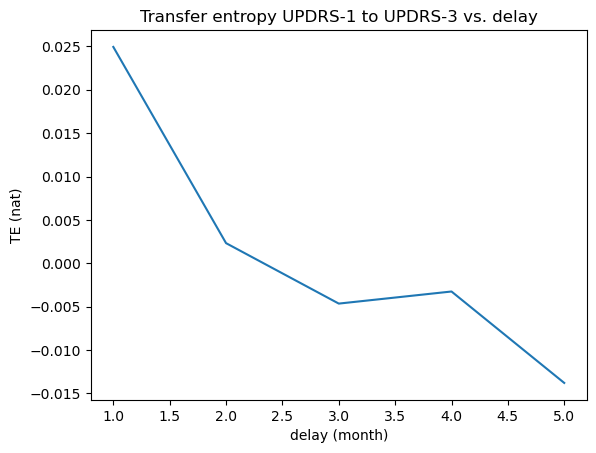

In [6]:
# 0. Load/prepare the data:

source = jpype.JArray(jpype.JDouble, 1)(df_pointwise_55["updrs_1_dt"].tolist())
destination = jpype.JArray(jpype.JDouble, 1)(df_pointwise_55["updrs_3_dt"].tolist())

delays = np.arange(1, 6, 1)
optimal_tes = []
best_te = 0
best_k_history = None

for k_history in np.arange(3, 12, 1):
    tes = []
    for delay in delays:
        te = calculate_te(
            df_pointwise_55,
            "updrs_1_dt", "updrs_3_dt", delay=delay, k_history=9)
        tes.append(te)
    if max(tes) > best_te:
        best_te = max(tes)
        best_k_history = k_history
        optimal_tes = tes
print(f'best te: {best_te}; best k_history: {best_k_history}')

plt.plot(delays, optimal_tes)
plt.xlabel('delay (month)')
plt.ylabel('TE (nat)')
plt.title('Transfer entropy UPDRS-1 to UPDRS-3 vs. delay')

Find best TE values for each permutation of UPDRS, with corresponding best $k$ and delays. Table below shows the transfer entropy across layers, in descending order.

In [13]:
# 0. Load/prepare the data:

te_data = {'source': [], 'target': [], 'TE value': [], 'best k': [], 'delay': []}
updrs_columns = [f"updrs_{i}_dt" for i in (1, 2, 3, 4)]
for source_column in updrs_columns:
    for target_column in updrs_columns:
        if target_column == source_column:
            continue
        source = jpype.JArray(jpype.JDouble, 1)(
            df_pointwise_55[source_column].tolist())
        destination = jpype.JArray(jpype.JDouble, 1)(
            df_pointwise_55[target_column].tolist())

        delays = np.arange(1, 12, 1)
        optimal_tes = []
        best_te = -100
        best_delay = None
        best_k_history = None

        for k_history in np.arange(3, 18, 1):
            for delay in delays:
                te = calculate_te(
                    df_pointwise_55,
                    source_column, target_column, delay=delay, k_history=k_history)
                if te > best_te:
                    best_te = te
                    best_k_history = k_history
                    best_delay = delay
                    optimal_tes = tes
        te_data['source'].append(source_column)
        te_data['target'].append(target_column)
        te_data['TE value'].append(best_te)
        te_data['best k'].append(best_k_history)
        te_data['delay'].append(best_delay)
te_table = pd.DataFrame(te_data)
te_table = te_table.sort_values(by='TE value', ascending=False)

In [14]:
te_table

,source,target,TE value,best k,delay
7,updrs_3_dt,updrs_2_dt,0.128069,3,5
2,updrs_1_dt,updrs_4_dt,0.092757,3,4
4,updrs_2_dt,updrs_3_dt,0.092550,6,11
0,updrs_1_dt,updrs_2_dt,0.066600,6,9
8,updrs_3_dt,updrs_4_dt,0.065779,6,5
3,updrs_2_dt,updrs_1_dt,0.062755,4,9
6,updrs_3_dt,updrs_1_dt,0.058656,4,10
1,updrs_1_dt,updrs_3_dt,0.052832,7,1
5,updrs_2_dt,updrs_4_dt,0.047598,6,2
9,updrs_4_dt,updrs_1_dt,0.036593,3,4
